In [67]:
# основные библиотеки
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns

# разделение датасета на для обучения
from sklearn.model_selection import train_test_split

# модели обучения
from sklearn.linear_model import LinearRegression as LRegression
from sklearn.preprocessing import StandardScaler as StScaler

# метрики качества модели
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [10]:
# качаем датасет с кегла
od.download('https://www.kaggle.com/datasets/akshaydattatraykhare/data-for-admission-in-the-university')

Skipping, found downloaded files in ".\data-for-admission-in-the-university" (use force=True to force download)


In [11]:
df = pd.read_csv('data-for-admission-in-the-university/adm_data.csv')

In [17]:
# Смотрим что тут есть
# Похоже есть категориальные признаки Raiting, Research
# остальные данные вещественные
# предсказать надо Chance of Admit который в датасете меняется от 0.34 до 0.97
# чем выше Chance тем лучше
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [18]:
# все данные у нас численные, т.е. пригодные для линейной регрессии
# но надо удалить столбец с серийником тк он не несет никакой полезной информации
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [19]:
# гудбай серийник
df.drop(columns=['Serial No.'], inplace=True)

In [32]:
# как оказалось название столбца с признаком вконце содержит пробел. надо поправить чтоб дальше проблем не было
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [34]:
df = df.rename(columns={'Chance of Admit ':'Chance_of_Admit'})

In [35]:
# чотенько
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


Text(0.5, 1.0, 'Distribution of chance')

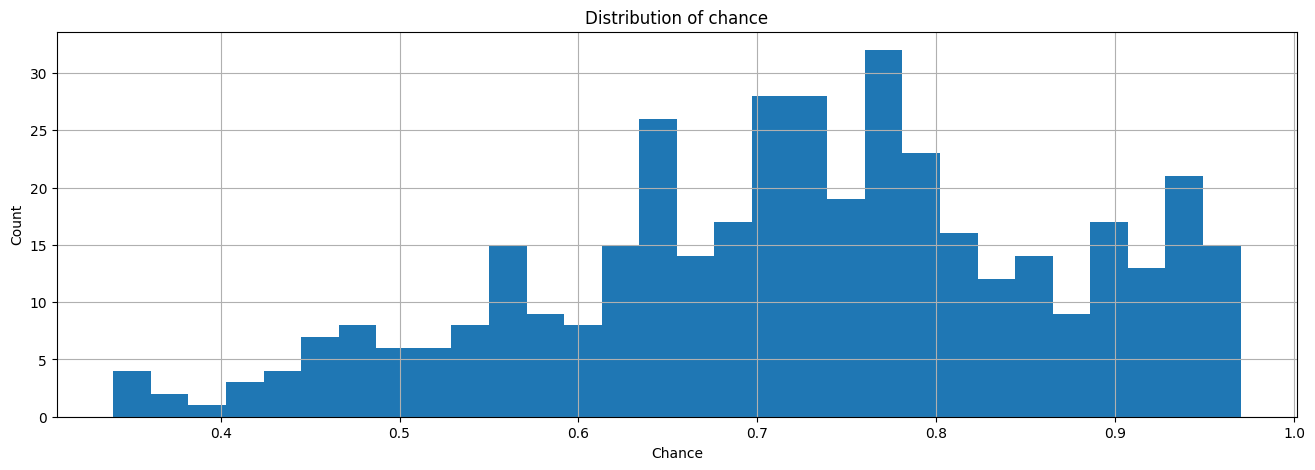

In [43]:
# смотрим какое разпределение имеет наш целевой признак
# в целом норм, выбросов / аномалий нет
plt.figure(figsize=(16,5))
df.Chance_of_Admit.hist(bins=30)
plt.xlabel('Chance')
plt.ylabel('Count')
plt.title('Distribution of chance')

In [44]:
# размер нашего датасета
df.shape

(400, 8)

In [134]:
# отделяем данные от нашего предсказываемого параметра
# делим на обучающую и тестовую выборки
x = df.drop(columns='Chance_of_Admit')
y = df.Chance_of_Admit
x_train_orig, x_test_orig, y_train, y_test = train_test_split(x,y,test_size=0.3, shuffle=True, random_state=True)

In [60]:
# разделение верное 120 / 400 =0.3
x_test_orig.shape

(120, 7)

<Axes: >

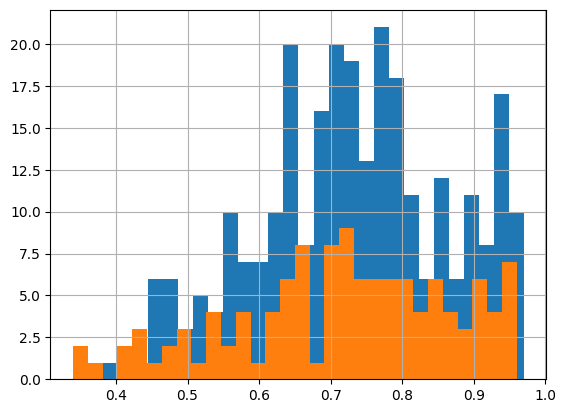

In [128]:
# распределеине в выборках вполне одинаковое
y_train.hist(bins=30)
y_test.hist(bins=30)

In [63]:
# Посмотрим что можно подчистить в обучающей выборке
# Пропусков нет
x_train_orig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 94 to 23
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          280 non-null    int64  
 1   TOEFL Score        280 non-null    int64  
 2   University Rating  280 non-null    int64  
 3   SOP                280 non-null    float64
 4   LOR                280 non-null    float64
 5   CGPA               280 non-null    float64
 6   Research           280 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 17.5 KB


In [65]:
# что с распределением признаков
# тоже все чисто
x_train_orig.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,317.003571,107.717857,3.060714,3.392857,3.451786,8.619357,0.553571
std,11.217465,5.878919,1.110342,0.953743,0.884148,0.563609,0.498012
min,293.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000
25%,309.000000,104.000000,2.000000,2.500000,3.000000,8.227500,0.000000
50%,317.000000,107.500000,3.000000,3.500000,3.500000,8.645000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000


In [135]:
# Теперь надо масштабировать датафрейм для более качественного обучения модели
# Нормализация (делим на разницу Макс-Мин) или стандартизация (делим на стандартное отклонение)
feature_names_for_stand = x_train_orig.columns
scaler = StScaler()
stand_features_train=scaler.fit_transform(x_train_orig[feature_names_for_stand])
stand_features_test=scaler.transform(x_test_orig[feature_names_for_stand])

In [72]:
# вышел нампаевский массив
stand_features_train

array([[-1.25060739, -1.48555657, -0.05477861, ..., -1.07842824,
        -1.70521651, -1.11355287],
       [ 0.35690632,  0.38888597, -0.05477861, ...,  1.7542163 ,
         0.40995787,  0.89802651],
       [-0.8040758 ,  0.2184821 , -0.95701447, ...,  0.62115848,
        -0.30102512, -1.11355287],
       ...,
       [-1.78644529, -1.99676817, -0.95701447, ..., -1.64495715,
        -2.11403172, -1.11355287],
       [-1.16130107, -0.97434497, -0.95701447, ...,  0.62115848,
         0.19666297, -1.11355287],
       [ 1.51788843,  1.92252077,  1.74969312, ...,  1.18768739,
         1.92079671,  0.89802651]], shape=(280, 7))

In [136]:
# перезапишем стандартизированный датасет
x_train_orig[feature_names_for_stand]=stand_features_train
x_test_orig[feature_names_for_stand]=stand_features_test

In [78]:
x_test_orig.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
238,-0.625463,-0.633537,-0.054779,-1.463026,0.054630,-0.443222,-1.113553
233,-1.161301,-1.315153,-0.957014,-0.937837,0.054630,-0.976459,-1.113553
384,2.053726,0.900098,0.847457,1.688107,1.754216,1.991895,0.898027
361,1.517888,1.411309,0.847457,0.637729,0.054630,1.636404,0.898027
173,0.535519,0.900098,0.847457,0.637729,1.187687,1.085392,0.898027


In [105]:
# переходим к обучению модели
# используем rmse и r2

# функция для визуализации результатов обучения 
def evaluate_preds (true_val, pred_val):
    print(
        'R2:\t'+str(round(r2(true_val, pred_val), 3))+'\n'+
        'RMSE:\t'+str(round(np.sqrt(mse(true_val,pred_val)),3))+'\n'        
    )
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=pred_val, y=true_val)
    plt.plot([0.3,1],[0.3,1], linestyle='--', color='b')

    plt.xlabel('Predictioin')
    plt.ylabel('True values')
    plt.title('Scatterplot of Predictions and Trues')
    


In [137]:
# начинается магия
lr_model=LRegression()
# обучаем на тренировочной выборке
lr_model.fit(x_train_orig, y_train)

LinearRegression()

In [82]:
# коэффициенты при предикторе
lr_model.coef_

array([ 0.01366244,  0.01328028,  0.0093628 , -0.00393351,  0.02231021,
        0.07458624,  0.0107851 ])

In [83]:
# коэффициент при интерсепте
lr_model.intercept_

np.float64(0.7255357142857143)

In [138]:
# сохраняем предсказанные значения
# размер тестовой выборки = 0.7 как и былО
y_train_pred = lr_model.predict(x_test_orig)
y_train_pred.shape

(120,)

R2:	0.81
RMSE:	0.066



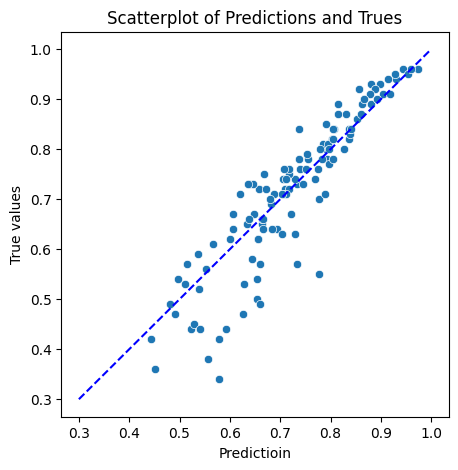

In [139]:
# глянем что вышло
# судя по показателям наша модель удалась
evaluate_preds(y_test,y_train_pred)

In [140]:
# По показателю R2 наша модель вполне хорошо справляется с предсказанием тк он -> к 1
# По RMSE тоже все красиво, тк среднее отклонение очень маленькое
import sklearn as skl

In [144]:
skl.__version__

'1.6.1'

In [146]:
pip freeze >> versions.txt

Note: you may need to restart the kernel to use updated packages.
